In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
df = pd.read_csv("C:/Users/admin/Downloads/cleaned (1).csv", encoding="latin-1")

In [8]:
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

# Convert 'Order_Date' and 'Ship_Date' to datetime objects first
for col in ['Order_Date', 'Ship_Date']:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Handle potential errors during conversion

# Now apply toordinal()
for col in ['Order_Date', 'Ship_Date']:
    df[col] = df[col].apply(lambda x: x.toordinal() if pd.notna(x) else x)
# Define features (X) and target variable (y)
X = df.drop(columns=["Sales"])
y = df["Sales"]

# Before splitting, convert categorical features to numerical using Label Encoding
categorical_features = X.select_dtypes(include=['object']).columns  # Select categorical columns

for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])


In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Import StandardScaler along with LabelEncoder
from sklearn.decomposition import PCA
df_encoded = df.copy()
categorical_cols = df.select_dtypes(include=['object']).columns
encoder = LabelEncoder()

for col in categorical_cols:
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

# Convert 'Order_Date' and 'Ship_Date' to ordinal before scaling
# Assuming 'Order_Date' and 'Ship_Date' are in the DataFrame
for col in ['Order_Date', 'Ship_Date']:
    df_encoded[col] = pd.to_datetime(df_encoded[col]).apply(lambda x: x.toordinal())

# Define features (X) and target variable (y)
X = df_encoded.drop(columns=["Sales"])
y = df_encoded["Sales"]

# Standardize the data (PCA requires scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Now X contains only numerical data

# Apply PCA
# pca = PCA()
# X_pca = pca.fit_transform(X_scaled)
pca = PCA(n_components=11)
X_pca = pca.fit_transform(X_scaled)
print("Shape of X_pca:", X_pca.shape)  # Should be (number_of_samples, 11)
print("Number of components generated by PCA:", pca.n_components_)


Shape of X_pca: (9799, 11)
Number of components generated by PCA: 11


In [10]:
# explained_variance = np.cumsum(pca.explained_variance_ratio_)
# optimal_components = np.argmax(explained_variance >= 0.3) + 1
# print("Optimal number of components to retain 95% variance:", optimal_components)

# Apply PCA with the optimal number of components
pca_optimal = PCA(n_components=11)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)
print("Shape of X_pca_optimal:", X_pca_optimal.shape)

Shape of X_pca_optimal: (9799, 11)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam

# Assuming X and y are already defined and loaded (X should have 16 features)

# Step 1: Feature Scaling
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)  # Scale the original dataset with 16 features

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()  # Scale the target variable

# Step 2: Define the Model Architecture
model = Sequential([
    Dense(256, input_dim=16),  # Input dimension matches the 16 features
    ReLU(),
    Dropout(0.3),
    Dense(128),
    ReLU(),
    Dropout(0.3),
    Dense(64),
    ReLU(),
    Dropout(0.3),
    Dense(1, activation='linear')  # Use 'linear' for regression tasks
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Step 3: Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 4: Train the Model
history = model.fit(X_scaled, y_scaled, epochs=350, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Step 5: Evaluate the Model
loss, mae = model.evaluate(X_scaled, y_scaled)
print(f'Mean Absolute Error: {mae}')

# Step 6: Make Predictions
y_pred_scaled = model.predict(X_scaled)

# Step 7: Convert Predictions Back to Original Scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Step 8: Calculate R2 Score
r2 = r2_score(y, y_pred)
print(f'R2 Score: {r2}')

Epoch 1/350


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9999 - mae: 0.8124 - val_loss: 0.7898 - val_mae: 0.7056
Epoch 2/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8457 - mae: 0.7197 - val_loss: 0.7495 - val_mae: 0.6595
Epoch 3/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8078 - mae: 0.6947 - val_loss: 0.6830 - val_mae: 0.6238
Epoch 4/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7425 - mae: 0.6615 - val_loss: 0.6741 - val_mae: 0.6119
Epoch 5/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7044 - mae: 0.6387 - val_loss: 0.6449 - val_mae: 0.6157
Epoch 6/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7187 - mae: 0.6442 - val_loss: 0.6537 - val_mae: 0.5993
Epoch 7/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7045 - mae: 0.6271 - val_loss: 0.6387 - val_mae: 0.6086
Epoch 8/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6786 - mae: 0.6190 - val_loss: 0.6339 - val_mae: 0.5962
Epoch 9/350
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss:

In [160]:
model.save("trained_model.h5")  # Save the entire model to a .h5 file
print("Model saved as trained_model.h5")

Model saved as trained_model.h5


In [161]:
import joblib
joblib.dump(encoder, "encoder.pkl")  
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [162]:
model.save_weights('trained_model.weights.h5')  # Saving model's weights

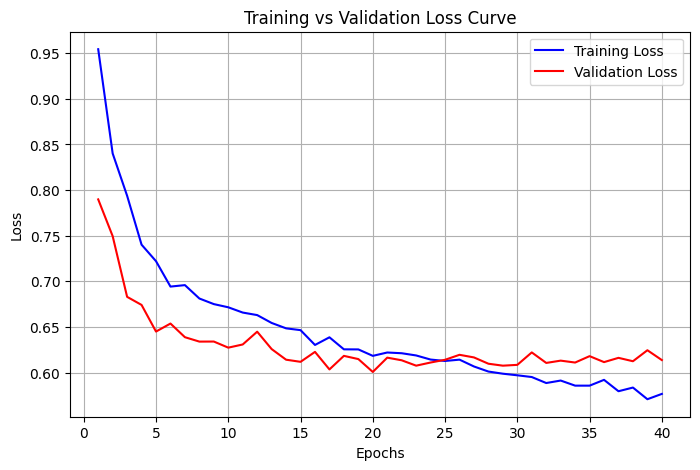

In [12]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss", color="blue")
plt.plot(epochs, val_loss, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
